In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import uproot
import awkward as ak
import tabulate as tab
import glob

from scipy.signal import find_peaks

In [75]:
def get_info(akw, display=False):
    Nevents    = len(akw['ch0']['waveforms'])
    TrigWindow = len(akw['ch0']['waveforms'][0])
    Nchannels  = len(akw.keys())
    maxima = []
    for chID in range(0, Nchannels):
        maxima.append(ak.max( akw[f'ch{chID}']['waveforms']) )
    if display:
        print(' events', Nevents)
        print(' trigger window', TrigWindow)
        print(' number of channels', Nchannels)
        print(' max height', int(np.max(maxima)) )
    return Nevents, TrigWindow, Nchannels, maxima

def open_file(file_path):
    file = uproot.open(file_path)
    return {
        tree_name.split(';')[0]: tree.arrays(library="ak")
        for tree_name, tree in file.items()
        if tree.classname.startswith("TTree")  # only trees
    }

def open_files(file_paths):
    # dictionary of all trees
    trees = {}
    with uproot.open(file_paths[0]) as f:
        for tree_name, tree in f.items():
            if tree.classname.startswith("TTree"):
                # concatenate over all files
                trees[tree_name.split(';')[0]] = uproot.concatenate(
                    [fp + ":" + tree_name.split(';')[0] for fp in file_paths],
                    library="ak"
                )
    return trees



In [76]:
cernbox = '/Users/emiliebertholet/cernbox/coldbox_data/waveform_nTuples'


In [77]:
# pns = open_file(f'{cernbox}/pns_nTuples_r25036_50-59.root')
# cos = open_file(f'{cernbox}/cos_nTuples_r25004_50-59.root')

In [ ]:
pns_files = [f'{cernbox}/pns_nTuples_r25036_50-59.root',
             f'{cernbox}/pns_nTuples_r25036_60-69.root']

pns = open_files(pns_files)
# cos = open_file(f'{cernbox}/cos_nTuples_r25004_50-59.root')

## 

In [5]:
print('PNS')
Nevents_pns, TrigWindow_pns, Nchannels_pns, maxima_pns = get_info(pns, display=True)
print('Cosmics')
Nevents_cos, TrigWindow_cos, Nchannels_cos, maxima_cos = get_info(cos, display=True)

ADCsat_pns = int(np.max(maxima_pns))
ADCsat_cos = int(np.max(maxima_cos))

if Nchannels_pns == Nchannels_cos:
    Nchannels = Nchannels_pns
else:
    print('soemthing is strange with the channels')

PNS
 events 3320
 trigger window 65600
 number of channels 12
 max height 16383
Cosmics
 events 840
 trigger window 262208
 number of channels 12
 max height 16383


# Pedestal Subtraction (sanity check)

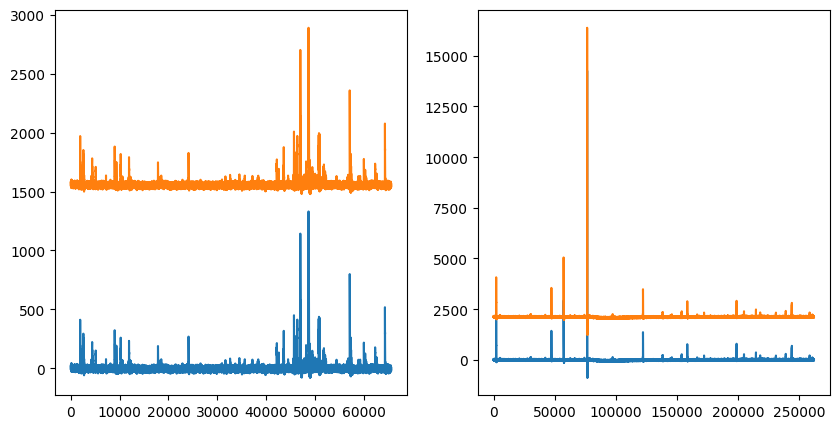

In [6]:
i = 2
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].plot(pns['ch0']['waveforms'][i])
axs[0].plot(pns['ch0']['waveforms'][i] + pns['ch0']['pedestals'][i])
axs[1].plot(cos['ch0']['waveforms'][i])
axs[1].plot(cos['ch0']['waveforms'][i] + cos['ch0']['pedestals'][i])
plt.show()

## Flag events with unstable baseline

In [7]:
cut = 40
lines = [['channel', 'PNS rejection [%]', 'Cosmics rejection [%]']]
rej_pns, rej_cos = [], []
for chID in range(Nchannels):
    sel_pns = pns[f'ch{chID}']['baseline_stability'][pns[f'ch{chID}']['baseline_stability']>40]
    rej_pns.append(len(sel_pns)*100/Nevents_pns)
    sel_cos = cos[f'ch{chID}']['baseline_stability'][cos[f'ch{chID}']['baseline_stability']>40]
    rej_cos.append(len(sel_cos)*100/Nevents_cos)
    lines.append( [chID, f'{rej_pns[chID]:.1f}', f'{rej_cos[chID]:.1f}'] )
print(tab.tabulate(lines, headers="firstrow", tablefmt="github"))

|   channel |   PNS rejection [%] |   Cosmics rejection [%] |
|-----------|---------------------|-------------------------|
|         0 |                 8.9 |                     1.9 |
|         1 |                 2.1 |                    15   |
|         2 |                 9.6 |                    12.1 |
|         3 |                 9.3 |                     6.8 |
|         4 |                 6.3 |                    11   |
|         5 |                 7.5 |                    15.5 |
|         6 |                98.4 |                    73.2 |
|         7 |                 0   |                     0   |
|         8 |                30.6 |                    42.1 |
|         9 |                 0   |                   100   |
|        10 |               100   |                     0   |
|        11 |                 0   |                     0   |


# Extract Peaks

In [8]:
def find_peaks_2d(array_trigRecxTT, **kwargs):
    """
    Find peaks in a 2D waveform array (trigRec x tt).
    
    Args:
        array_2d: np.ndarray shape (N_trigRecs, N_tt)
        kwargs: arguments for `scipy.signal.find_peaks`, e.g. height, distance, width

    Returns:
        dict with:
            - 'peak_indices': list of np.arrays with peak positions
            - 'peak_heights': list of np.arrays with peak heights
            - 'properties': list of full peak properties per waveform
            - 'pulses': list of slices around peaks (if width info available)
    """
    props_list = []
    peak_indices = []
    peak_heights = []
    peak_slices = []

    for row_idx, row in enumerate(array_trigRecxTT):
        peaks, props = find_peaks(row, **kwargs)

        # getters
        heights  = props.get("peak_heights", row[peaks])
        # left_ips = props.get("left_ips", props)

        # Extract waveform slices around peaks (if widths are calculated)
        slices = []
        if "left_ips" in props and "right_ips" in props:
            for l, r in zip(props["left_ips"], props["right_ips"]):
                start = max(0, int(np.floor(l)))
                end   = min(len(row), int(np.ceil(r)))
                slices.append(row[start:end])
        else:
            slices = [np.array([row[p]]) for p in peaks]  # fallback: just peak value

        # Collect
        props_list.append(props)
        peak_indices.append(peaks)
        peak_heights.append(heights)
        peak_slices.append(slices)

    return {
        "peak_indices": peak_indices,
        "peak_heights": peak_heights,
        "properties": props_list,
        "pulses": peak_slices,
    }

def test_plot(result, sample, chID, trigRec, avg=True, ADCsat=16383):
    print('Selection applied to test plot:')
    print('  - remove stauration')

    fig, axs = plt.subplots(1, 2, figsize=(11, 3))
    peak_indices = result[f'ch{chID}']['peak_indices'][trigRec]
    full_waveform = sample[f'ch{chID}']['waveforms'][trigRec]
    ax = axs[0]
    ax.plot(full_waveform, label="Trigger Record")
    ax.plot(peak_indices, full_waveform[peak_indices], "rx", label="Peaks")
    ax.set_xlabel('time ticks')
    ax.set_ylabel('ADC - pedestal')

    ax = axs[1]
    pulses_noSat = []
    for pulse in result[f'ch{chID}']['pulses'][trigRec]:
        if np.max(pulse)<ADCsat-sample[f'ch{chID}']['pedestals'][trigRec]:
            ax.plot( pulse, alpha=0.4 );
            pulses_noSat.append(pulse)
    if avg:
        avg_pns = ak.mean(pulses_noSat, axis=0)
        ax.plot(avg_pns, color='black', label='average')
        ax.legend()
    ax.set_xlabel('time ticks')
    ax.set_ylabel('ADC - pedestal');

In [9]:
pns_result, cos_result = {}, {}
for chID in range(Nchannels):
    pns_result[f'ch{chID}'] = find_peaks_2d(pns[f'ch{chID}']['waveforms'],  distance=300, prominence=200, wlen=300, rel_height=0.9, width=0)
    cos_result[f'ch{chID}'] = find_peaks_2d(cos[f'ch{chID}']['waveforms'],  distance=300, prominence=200, wlen=300, rel_height=0.9, width=0)
pns_result['ch0'].keys()

/var/folders/80/x5l9nnmd2gb3szz23pnjrgpm0000gn/T/ipykernel_30535/3432605860.py:22: PeakPropertyWarning: some peaks have a prominence of 0
  peaks, props = find_peaks(row, **kwargs)


dict_keys(['peak_indices', 'peak_heights', 'properties', 'pulses'])

Selection applied to test plot:
  - remove stauration


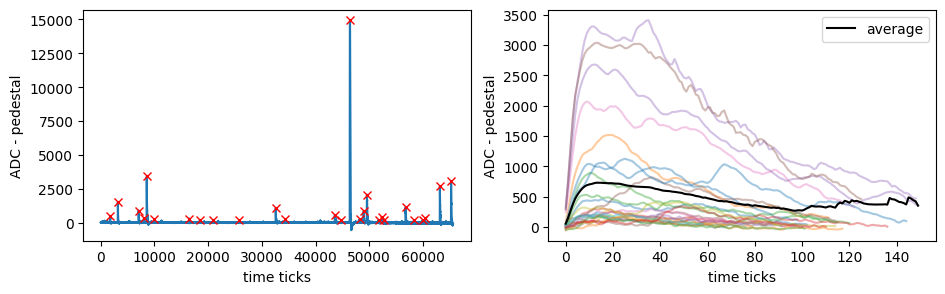

In [ ]:
chID = 0
test_plot(pns_result, pns, chID, trigRec=30, avg=True,  ADCsat=ADCsat_pns)
# test_plot(cos_result, cos, chID, trigRec=30, avg=True,  ADCsat=ADCsat_cos)

Selection applied to test plot:
  - remove stauration


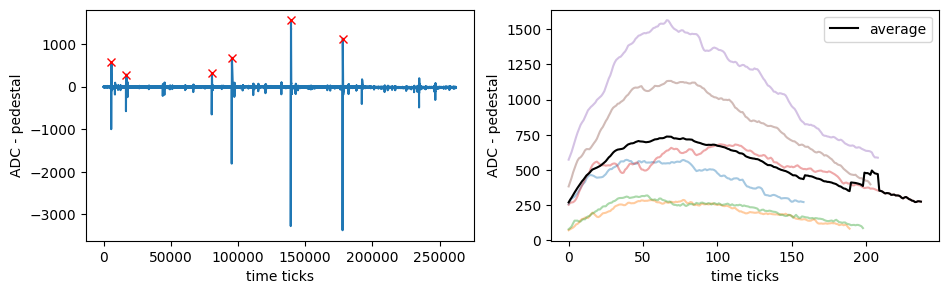

In [10]:
test_plot(cos_result, cos, chID, trigRec=30, avg=True,  ADCsat=ADCsat_cos)

# Selection

In [16]:
def apply_selection(result, sample, chID, ADCsat, rms_cut, max_peak_position, time_tick_range, minPeak_height, ADCspread, maxADC_range):

    res = result[f'ch{chID}']
    sam = sample[f'ch{chID}']

    print('Selection:')
    print(f'  1. Remove saturated pulses')
    selected_pulses = [[pulse for pulse in trigRec if np.max(pulse)<ADCsat-sam['pedestals'][idx]] for idx, trigRec in enumerate(res['pulses']) ]

    if rms_cut is not None: 
        print(f'  2. Keep only trigger records with stable baseline (baseline RMS = {rms_cut})')
        baseline_stability = sam['baseline_stability']
        selected_pulses  = [[pulse for pulse in selected_pulses[i] if baseline_stability[i]<rms_cut] for i in range(len(selected_pulses))]

    if max_peak_position is not None: 
        print(f'  3. Keep pulses with peak position < {max_peak_position} ticks')
        selected_pulses  = [[pulse for pulse in selected_pulses[i] if np.argmax(pulse)<max_peak_position] for i in range(len(selected_pulses))]

    if time_tick_range is not None: 
        print(f'  4. Keep pulses with length in range {time_tick_range} ticks')
        selected_pulses  = [[pulse for pulse in selected_pulses[i] if time_tick_range[0]<len(pulse)<time_tick_range[1]] for i in range(len(selected_pulses))]

    if minPeak_height is not None: 
        print(f'  5. Keep pulses with peak height > {minPeak_height} ADCs')
        selected_pulses  = [[pulse for pulse in selected_pulses[i] if np.max(pulse) > minPeak_height  ] for i in range(len(selected_pulses))]
    
    if ADCspread is not None: 
        print(f'  6. Remove pulses with peak-to-peak spread < {ADCspread} ADCs')
        selected_pulses  = [[pulse for pulse in selected_pulses[i] if abs( np.max(pulse) -  np.min(pulse) )>ADCspread] for i in range(len(selected_pulses))]

    if maxADC_range is not None: 
        print(f'  7. Keep pulses with max value in range {maxADC_range} ADCs')
        selected_pulses  = [[pulse for pulse in selected_pulses[i] if maxADC_range[0] < np.max(pulse) < maxADC_range[1]  ] for i in range(len(selected_pulses))]

    pulses_flat = [sub for group in selected_pulses for sub in group]
    return pulses_flat, selected_pulses


In [13]:
chID=0
ADCsat = ADCsat_pns
rms_cut=40
max_peak_position=30

time_tick_range = (80, 120)
ADCspread = 100 #500
minPeak_height = 0 
maxADC_range = None

pns_sel_flat, selected_pulses = apply_selection(pns_result, pns, chID, ADCsat, rms_cut, max_peak_position, time_tick_range, minPeak_height, ADCspread, maxADC_range)

pulses_flat = [sub for group in pns_result[f'ch{chID}']['pulses'] for sub in group]
print(f'sel efficiency = {len(pns_sel_flat)*100/len(pulses_flat):.1f} %  ({len(pns_sel_flat)} pulses selected out of {len(pulses_flat)} pulses)')

Selection:
  1. Remove saturated pulses
  2. Keep only trigger records with stable baseline (baseline RMS = 40)
  3. Keep pulses with peak position < 30 ticks
  4. Keep pulses with length in range (80, 120) ticks
  5. Keep pulses with peak height > 0 ADCs
  6. Remove pulses with peak-to-peak spread < 100 ADCs
sel efficiency = 27.2 %  (26288 pulses selected out of 96688 pulses)


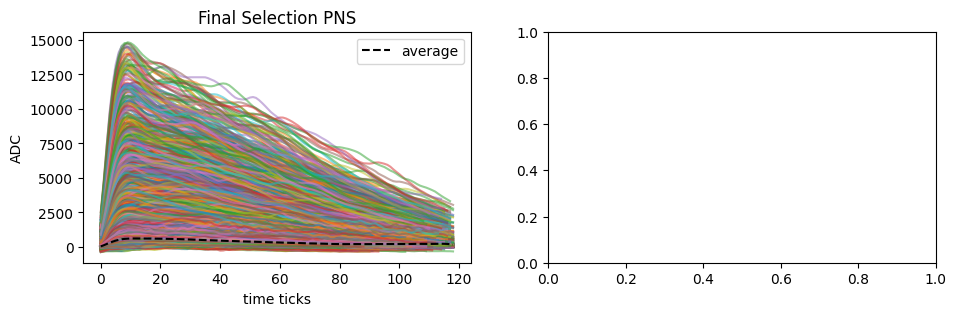

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(11, 3))
ax = axs[0]
for wf in pns_sel_flat:
    ax.plot(wf, alpha=0.5) 

avg_pns = ak.mean(pns_sel_flat, axis=0)
ax.plot(avg_pns, color='black', linestyle='--', label='average')
ax.legend()

ax.set_title(f"Final Selection PNS")
ax.set_xlabel("time ticks")
ax.set_ylabel("ADC")
plt.show()

In [21]:
ADCsat = ADCsat_pns
rms_cut=40
max_peak_position=30

time_tick_range = (80, 120)
ADCspread = 100 #500
minPeak_height = 0 
maxADC_range = None

pns_selection = {}
for chID in range(Nchannels):
    pns_selection[f'ch{chID}'] = apply_selection(pns_result, pns, chID, ADCsat, rms_cut, max_peak_position, time_tick_range, minPeak_height, ADCspread, maxADC_range)[0]
    pulses_flat = [sub for group in pns_result[f'ch{chID}']['pulses'] for sub in group]
    e = len(pns_selection[f'ch{chID}'])*100/len(pulses_flat) if len(pulses_flat) > 0 else 0
    print(f'ch{chID} selection efficiency = {e:.1f} %  ({len(pns_sel_flat)} pulses selected out of {len(pulses_flat)} pulses)')

Selection:
  1. Remove saturated pulses
  2. Keep only trigger records with stable baseline (baseline RMS = 40)
  3. Keep pulses with peak position < 30 ticks
  4. Keep pulses with length in range (80, 120) ticks
  5. Keep pulses with peak height > 0 ADCs
  6. Remove pulses with peak-to-peak spread < 100 ADCs
ch0 selection efficiency = 27.2 %  (26288 pulses selected out of 96688 pulses)
Selection:
  1. Remove saturated pulses
  2. Keep only trigger records with stable baseline (baseline RMS = 40)
  3. Keep pulses with peak position < 30 ticks
  4. Keep pulses with length in range (80, 120) ticks
  5. Keep pulses with peak height > 0 ADCs
  6. Remove pulses with peak-to-peak spread < 100 ADCs
ch1 selection efficiency = 28.6 %  (26288 pulses selected out of 37570 pulses)
Selection:
  1. Remove saturated pulses
  2. Keep only trigger records with stable baseline (baseline RMS = 40)
  3. Keep pulses with peak position < 30 ticks
  4. Keep pulses with length in range (80, 120) ticks
  5. Ke

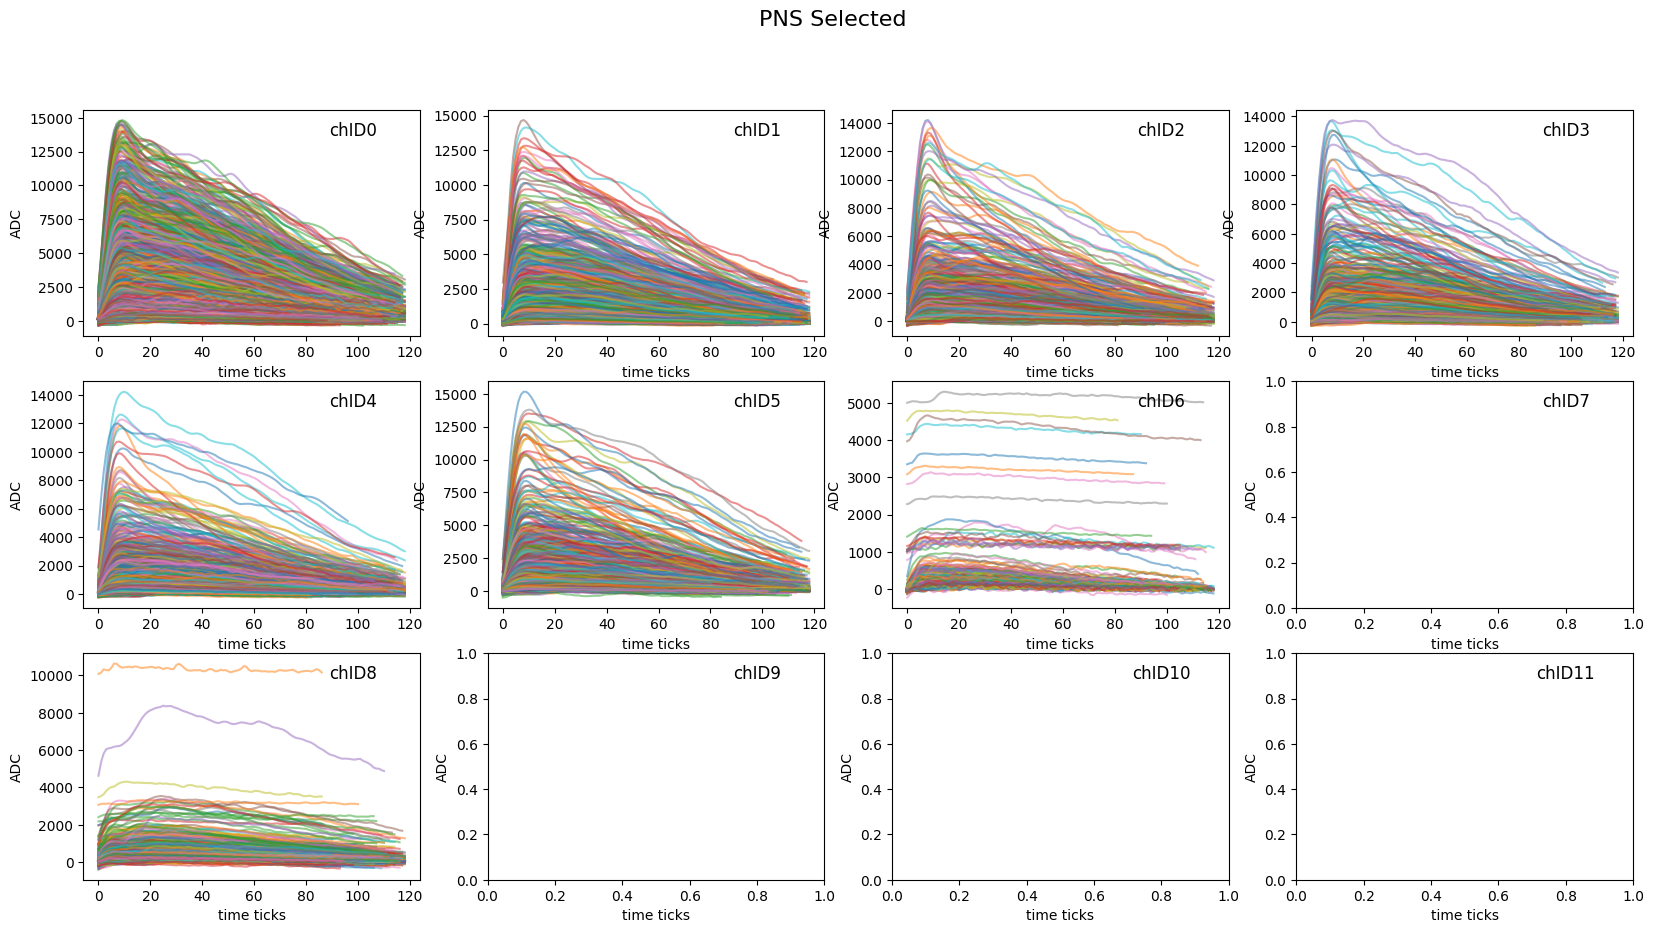

In [29]:

fig, axs = plt.subplots(3, 4, figsize=(20, 10))
fig.suptitle(f'PNS Selected', fontsize=16)
for chID in range(Nchannels):
# for chID in range(1):
    ax = axs.flatten()[chID]
    for p in range(len(pns_selection[f'ch{chID}'])):
        ax.plot(pns_selection[f'ch{chID}'][p], alpha=0.5)
    ax.set_xlabel('time ticks')
    ax.set_ylabel('ADC')
    ax.set_title(f'chID{chID}', x=0.8,  y = 0.85)
plt.show()

In [30]:
cos_selection = {}

for chID in range(Nchannels):
    cos_selection[f'ch{chID}'] = apply_selection(cos_result, cos, chID, ADCsat, rms_cut, max_peak_position, time_tick_range, minPeak_height, ADCspread, maxADC_range)[0]
    pulses_flat = [sub for group in cos_result[f'ch{chID}']['pulses'] for sub in group]
    e = len(cos_selection[f'ch{chID}'])*100/len(pulses_flat) if len(pulses_flat) > 0 else 0
    print(f'ch{chID} selection efficiency = {e:.1f} %  ({len(pns_sel_flat)} pulses selected out of {len(pulses_flat)} pulses)')

Selection:
  1. Remove saturated pulses
  2. Keep only trigger records with stable baseline (baseline RMS = 40)
  3. Keep pulses with peak position < 30 ticks
  4. Keep pulses with length in range (80, 120) ticks
  5. Keep pulses with peak height > 0 ADCs
  6. Remove pulses with peak-to-peak spread < 100 ADCs
ch0 selection efficiency = 26.1 %  (26288 pulses selected out of 12234 pulses)
Selection:
  1. Remove saturated pulses
  2. Keep only trigger records with stable baseline (baseline RMS = 40)
  3. Keep pulses with peak position < 30 ticks
  4. Keep pulses with length in range (80, 120) ticks
  5. Keep pulses with peak height > 0 ADCs
  6. Remove pulses with peak-to-peak spread < 100 ADCs
ch1 selection efficiency = 23.7 %  (26288 pulses selected out of 18613 pulses)
Selection:
  1. Remove saturated pulses
  2. Keep only trigger records with stable baseline (baseline RMS = 40)
  3. Keep pulses with peak position < 30 ticks
  4. Keep pulses with length in range (80, 120) ticks
  5. Ke

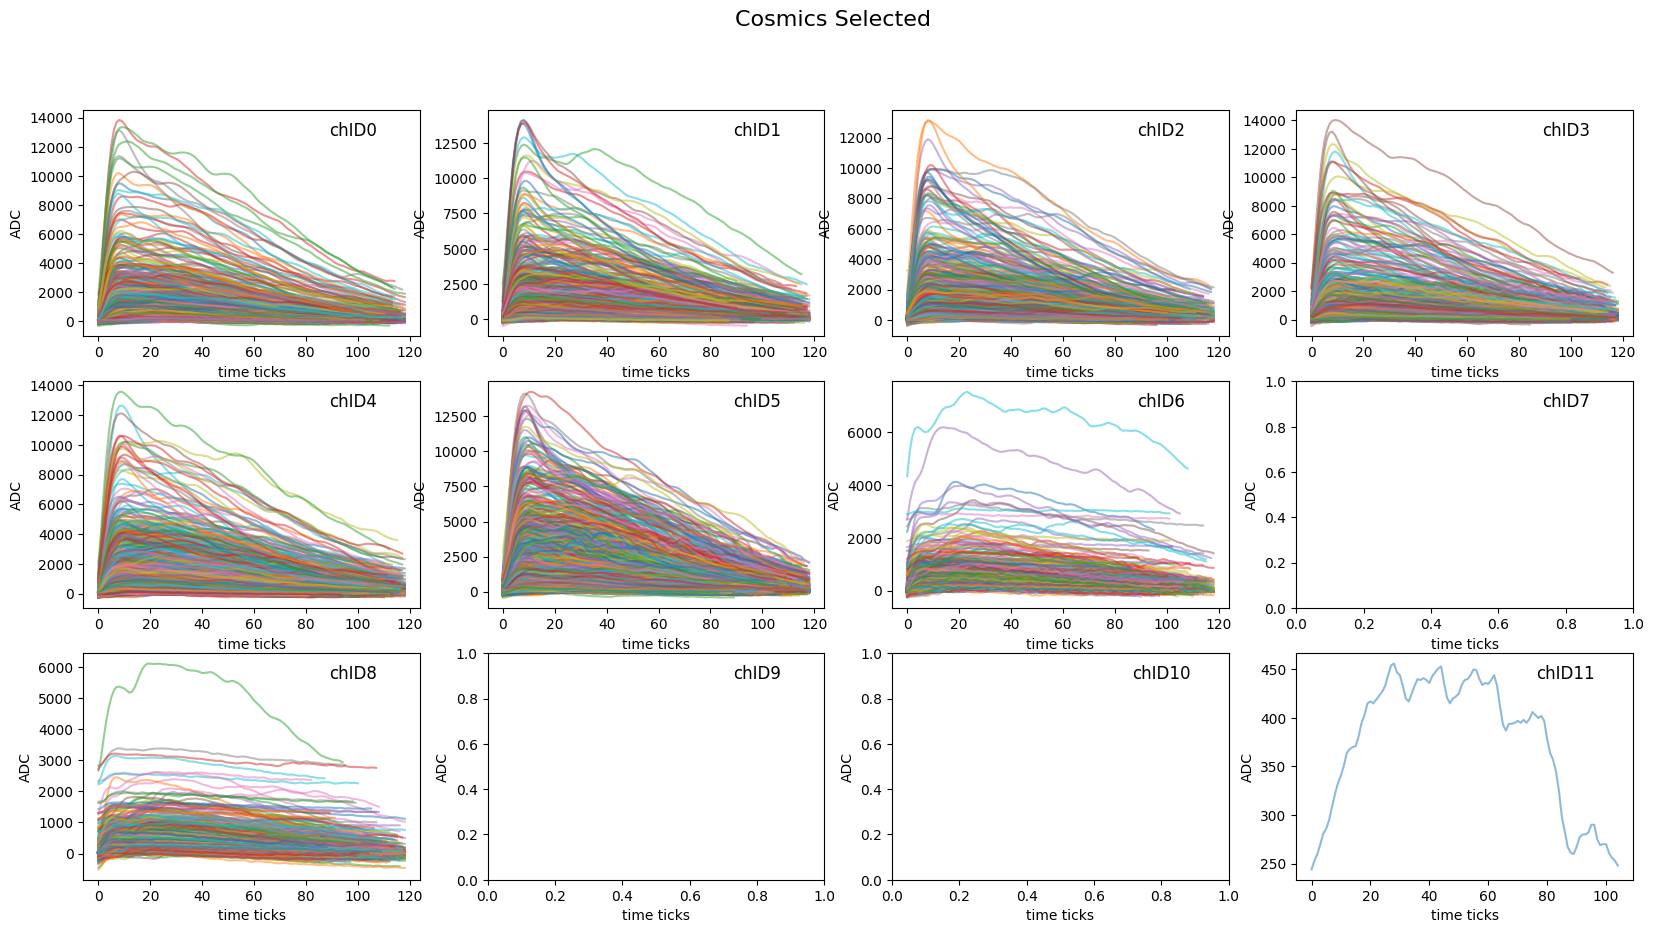

In [31]:
fig, axs = plt.subplots(3, 4, figsize=(20, 10))
fig.suptitle(f'Cosmics Selected', fontsize=16)
for chID in range(Nchannels):
    ax = axs.flatten()[chID]
    for p in range(len(cos_selection[f'ch{chID}'])):
        ax.plot(cos_selection[f'ch{chID}'][p], alpha=0.5)
    ax.set_xlabel('time ticks')
    ax.set_ylabel('ADC')
    ax.set_title(f'chID{chID}', x=0.8,  y = 0.85)
plt.show()

In [51]:
def Normalized_mean(selection):
    if len(selection) == 0:
        normed_mean = 0
    else:
        mean = ak.mean(selection, axis=0)
        norm = ak.sum(mean) 
        if norm == 0 or np.isnan(norm):
            normed_mean = 0   
        else:
            normed_mean = mean / norm
    return normed_mean



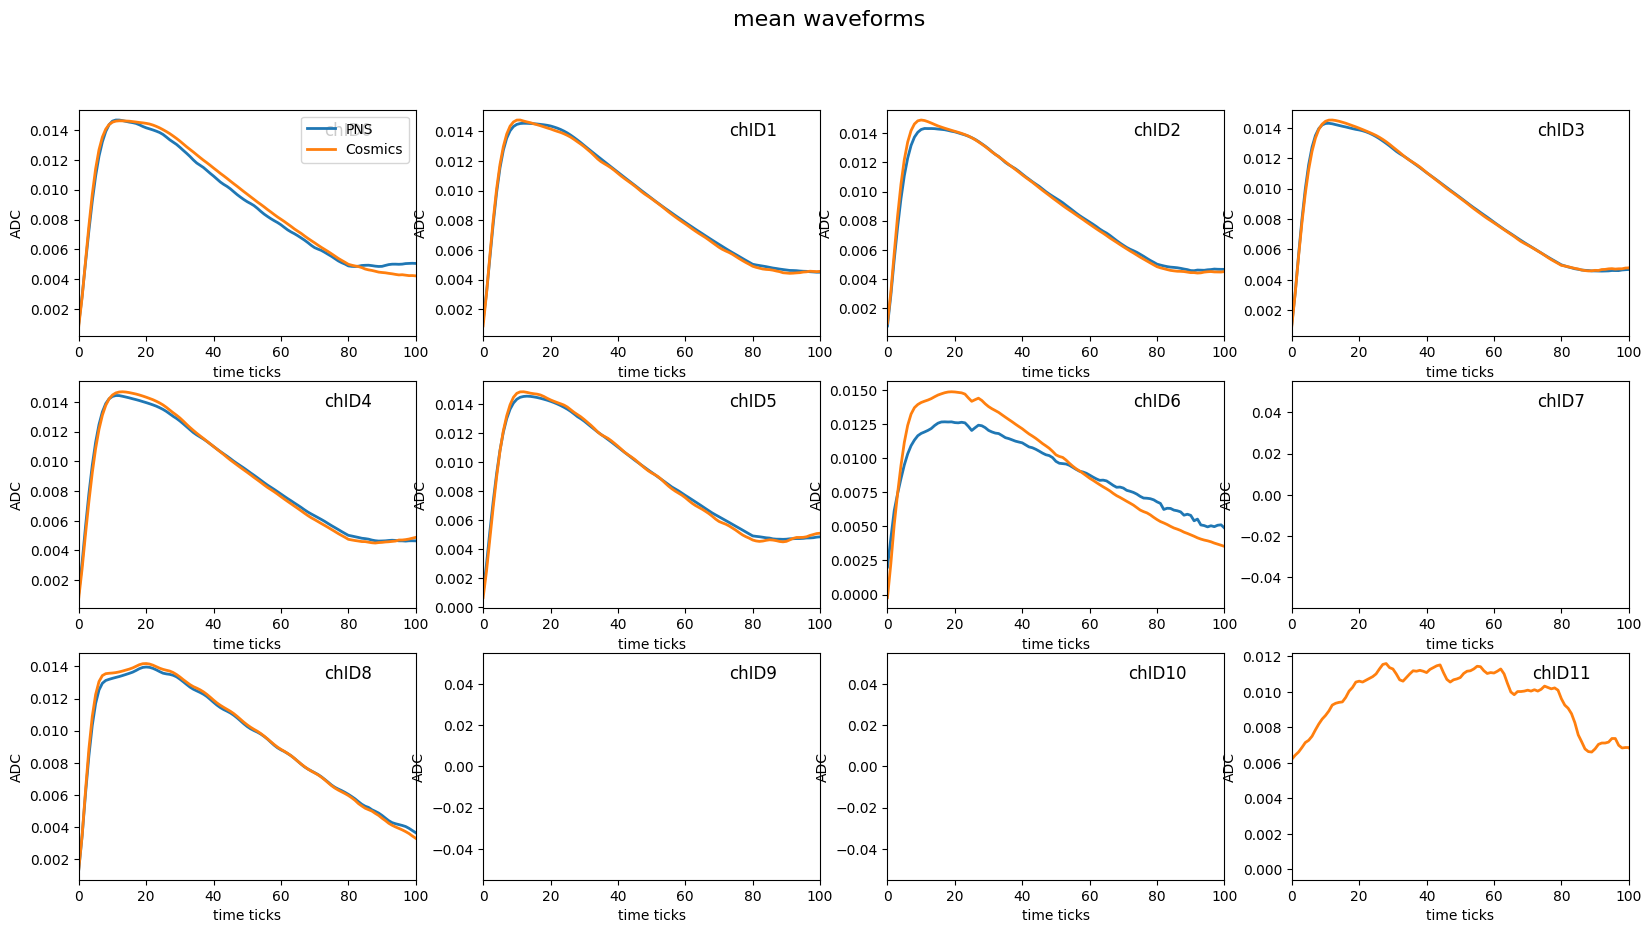

In [53]:
fig, axs = plt.subplots(3, 4, figsize=(20, 10))
fig.suptitle(f'mean waveforms', fontsize=16)
for chID in range(Nchannels):
    ax = axs.flatten()[chID]
    mean_pns = Normalized_mean(pns_selection[f'ch{chID}']) 
    mean_cos = Normalized_mean(cos_selection[f'ch{chID}']) 
    ax.plot(mean_pns, linewidth=2, label='PNS')
    ax.plot(mean_cos, linewidth=2, label='Cosmics')
    if chID==0: ax.legend()
    ax.set_xlabel('time ticks')
    ax.set_ylabel('ADC')
    ax.set_title(f'chID{chID}', x=0.8,  y = 0.85)
    ax.set_xlim(0, 100)
plt.show()

# PSD

In [54]:
def prompt_frac(waveforms, tot_int_boundaries, prompt_int_boundaries):
    promptFrac, Int, ratio = [], [], []
    for p in waveforms:
        p = np.asarray(p)
        peak_position = p.argmax()
        lim_inf = peak_position+prompt_int_boundaries[0]
        lim_sup = peak_position+prompt_int_boundaries[1]
        if lim_inf<0:
            lim_inf = 0
        pf = p[lim_inf:lim_sup].sum()
        integ = p[tot_int_boundaries[0]:tot_int_boundaries[1]].sum()
        r = pf/integ
        promptFrac.append( pf )
        Int.append( integ )
        ratio.append( r )
    return np.array(Int), np.array(ratio)

pns 26288
cos 3188


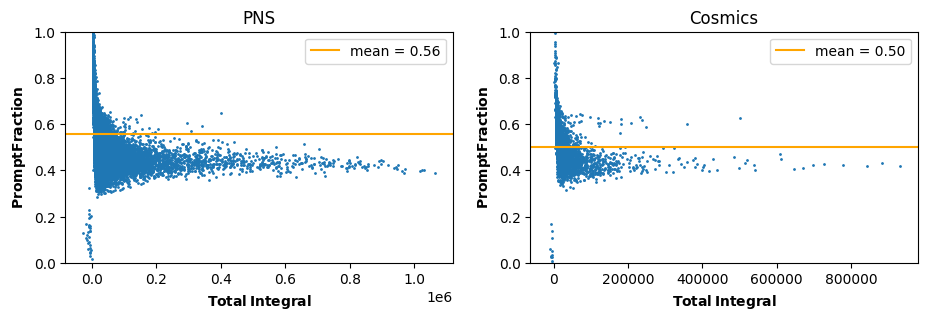

In [56]:
chID = 0

selected_pulses_flat_pns = pns_selection[f'ch{chID}']
selected_pulses_flat_cos = cos_selection[f'ch{chID}']
print('pns', len(selected_pulses_flat_pns))
print('cos', len(selected_pulses_flat_cos))


bmin_baseline, bmax_baseline = (0, 300)
prompt_boundaries = (-2,  30)

fig, axs = plt.subplots(1, 2, figsize=(11, 3))

ax = axs.flatten()[0]
Int_baseline_pns, ratio_baseline_pns = prompt_frac(selected_pulses_flat_pns, (bmin_baseline, bmax_baseline), prompt_boundaries)
ax.scatter(Int_baseline_pns, ratio_baseline_pns,  s=1)
mean = np.mean(ratio_baseline_pns)
ax.axhline(y = mean, color='orange', label=f'mean = {mean:.2f}')
ax.set_xlabel(r"$\mathrm{\bf Total \, Integral}$")
ax.set_ylabel(r"$\mathrm{\bf Prompt Fraction}$");
ax.set_title(f"PNS")
ax.legend()
ax.set_ylim(0, 1);
# plt.xlim(0, 1.5e6);

ax = axs.flatten()[1]
Int_baseline_cos, ratio_baseline_cos = prompt_frac(selected_pulses_flat_cos, (bmin_baseline, bmax_baseline), prompt_boundaries)
ax.scatter(Int_baseline_cos, ratio_baseline_cos,  s=1)
mean = np.mean(ratio_baseline_cos)
ax.axhline(y = mean, color='orange', label=f'mean = {mean:.2f}')
ax.set_xlabel(r"$\mathrm{\bf Total \, Integral}$")
ax.set_ylabel(r"$\mathrm{\bf Prompt Fraction}$");
ax.set_title("Cosmics")
ax.legend()
ax.set_ylim(0, 1);
# plt.xlim(0, 1.5e6);

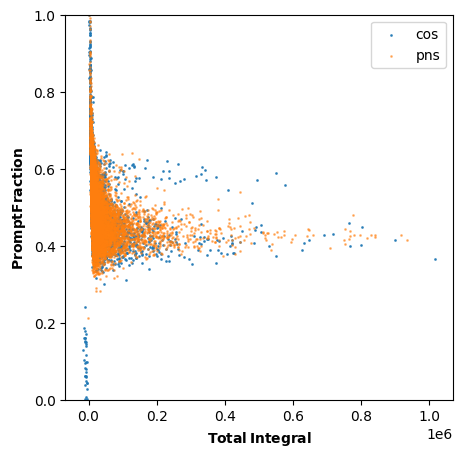

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

Int_baseline, ratio_baseline = prompt_frac(selected_pulses_flat_cos, (bmin_baseline, bmax_baseline), prompt_boundaries)
ax.scatter(Int_baseline, ratio_baseline,  s=1, alpha=0.8, label = 'cos')
Int_baseline, ratio_baseline = prompt_frac(selected_pulses_flat_pns, (bmin_baseline, bmax_baseline), prompt_boundaries)
ax.scatter(Int_baseline, ratio_baseline,  s=1, alpha=0.5, label = 'pns')

ax.set_xlabel(r"$\mathrm{\bf Total \, Integral}$")
ax.set_ylabel(r"$\mathrm{\bf Prompt Fraction}$");
ax.legend()
ax.set_ylim(0, 1);

pns 26288
cos 3188
pns 10733
cos 4409
pns 5754
cos 4162
pns 5479
cos 3873
pns 4861
cos 5684
pns 6698
cos 7343
pns 526
cos 8703
pns 10477
cos 6581


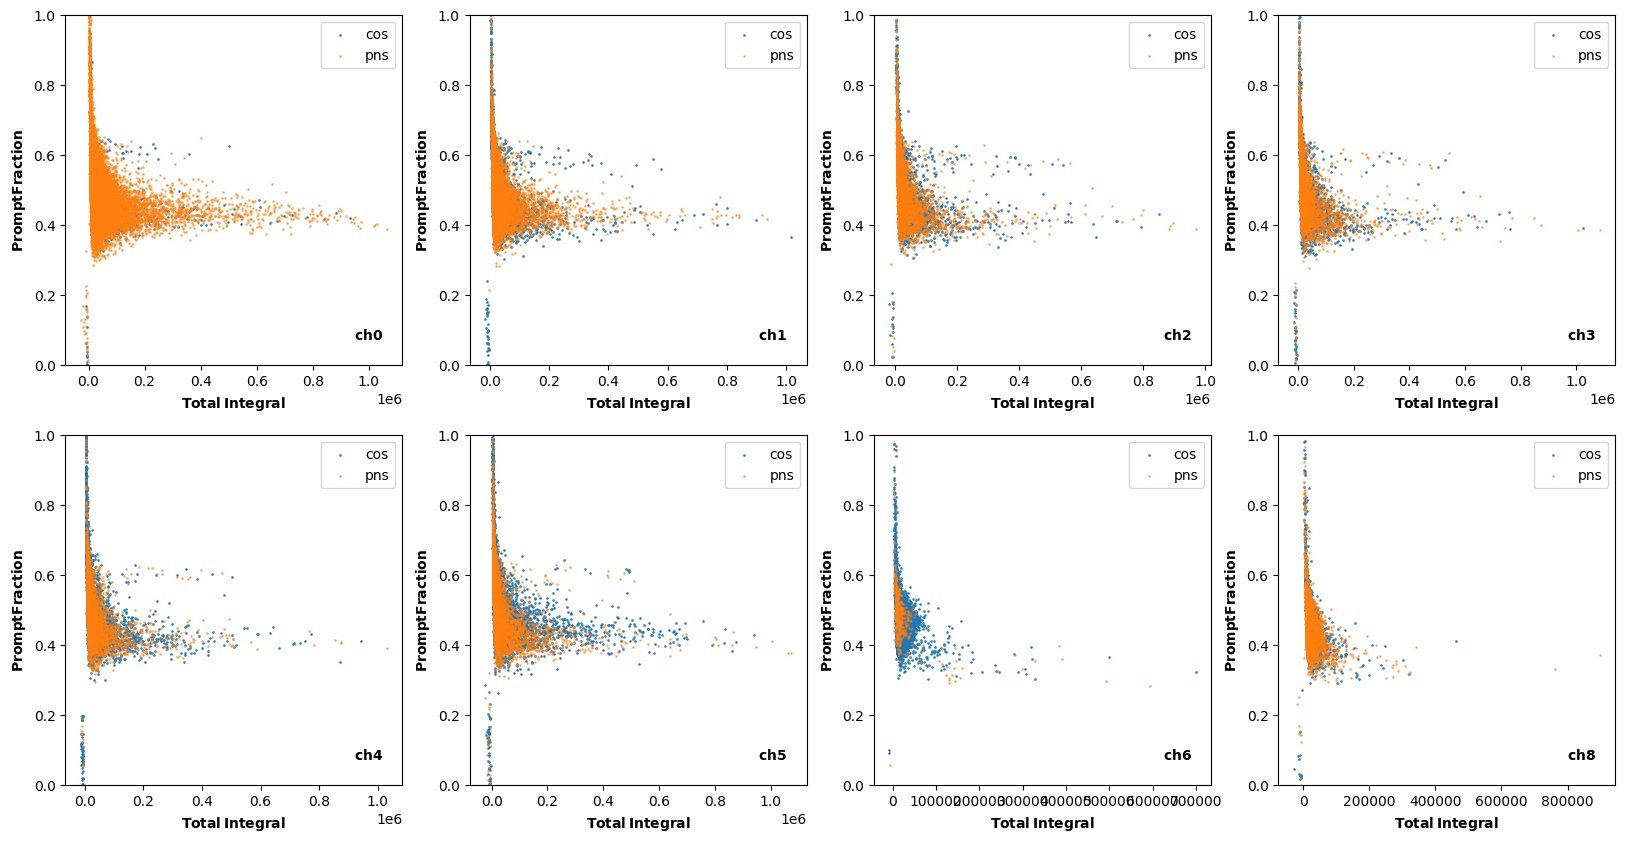

In [72]:


fig, axs = plt.subplots(2, 4, figsize=(20, 10))
i = 0
for chID in [0,1,2,3,4,5,6,8]:
    ax = axs.flatten()[i]
    selected_pulses_flat_pns = pns_selection[f'ch{chID}']
    selected_pulses_flat_cos = cos_selection[f'ch{chID}']
    print('pns', len(selected_pulses_flat_pns))
    print('cos', len(selected_pulses_flat_cos))
    Int_baseline, ratio_baseline = prompt_frac(selected_pulses_flat_cos, (bmin_baseline, bmax_baseline), prompt_boundaries)
    ax.scatter(Int_baseline, ratio_baseline,  s=1, alpha=0.8, label = 'cos')
    Int_baseline, ratio_baseline = prompt_frac(selected_pulses_flat_pns, (bmin_baseline, bmax_baseline), prompt_boundaries)
    ax.scatter(Int_baseline, ratio_baseline,  s=1, alpha=0.5, label = 'pns')
    ax.set_xlabel(r"$\mathrm{\bf Total \, Integral}$")
    ax.set_ylabel(r"$\mathrm{\bf Prompt Fraction}$");
    ax.set_title(rf"$\mathbf{{ch{chID}}}$", x=0.9, y=0.05, fontsize=10)
    ax.legend()
    ax.set_ylim(0, 1);
    i+=1